In [54]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pandas as pd
import torch
import os
import joblib
from torch import nn
import logging
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from math import sqrt
import numpy as np
import warnings
from util.best_model import BestModel
from util.upload_data import upload_data_to_db
from mlflow.tracking import MlflowClient
import mlflow
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'torch'

In [140]:
df = pd.read_excel('Inflation Rates data.xlsx', parse_dates=['Time'])

In [141]:
# Applying adjust year because upon reading excel the values are read as 1900s instead of 2000s

def adjust_year(d):
    date_str = d.strftime('%m-%Y')
    month, year = date_str.split('-')
    year = int(year)
    year += 100
    return f'{month}-{year}'

In [142]:
df['Time'] = df['Time'].apply(adjust_year)

In [143]:
df['Time'] = pd.to_datetime(df['Time'])

/tmp/ipykernel_3981/2145562215.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [144]:
df

,Time,INFR
0,2014-04-01,8.483
1,2014-05-01,8.326
2,2014-06-01,6.770
3,2014-07-01,7.387
4,2014-08-01,7.028
...,...,...
115,2023-11-01,5.550
116,2023-12-01,5.690
117,2024-01-01,5.100
118,2024-02-01,5.090


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    120 non-null    datetime64[ns]
 1   INFR    120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [41]:
import matplotlib.pyplot as plt

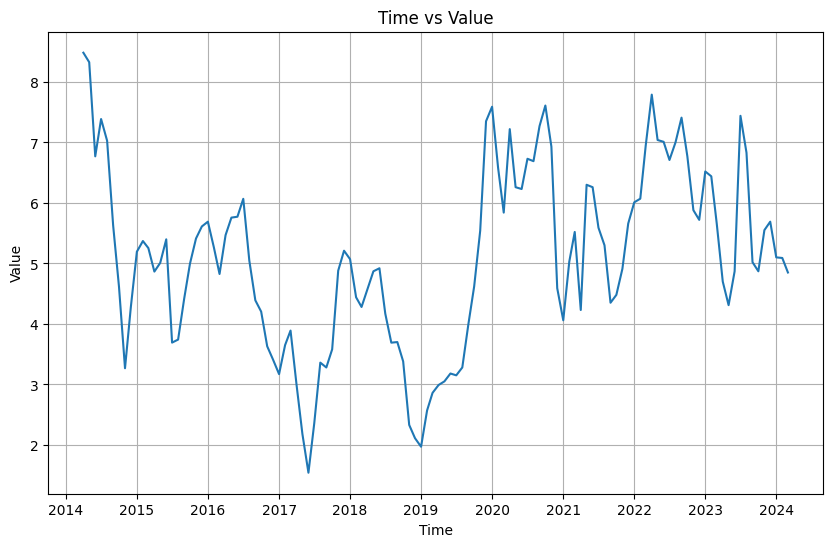

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['INFR'])
plt.title('Time vs Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

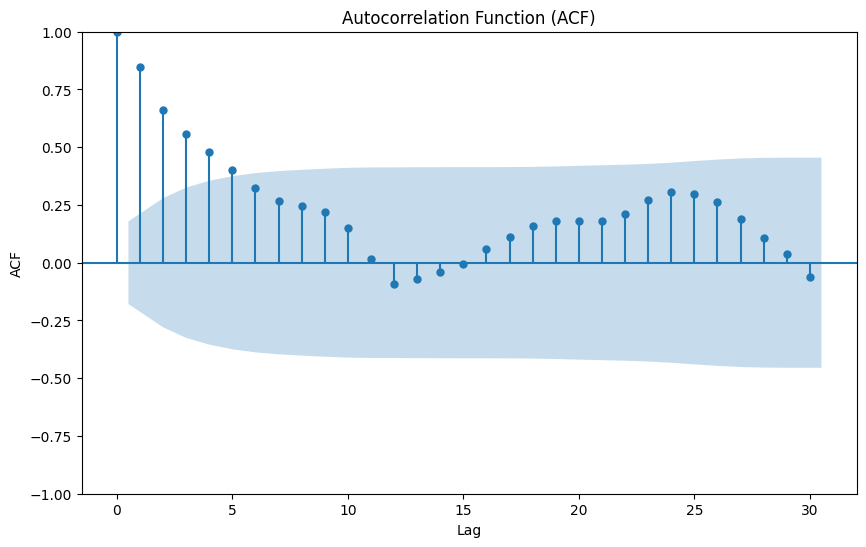

In [48]:
plt.figure(figsize=(10, 6))
plot_acf(df['INFR'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()


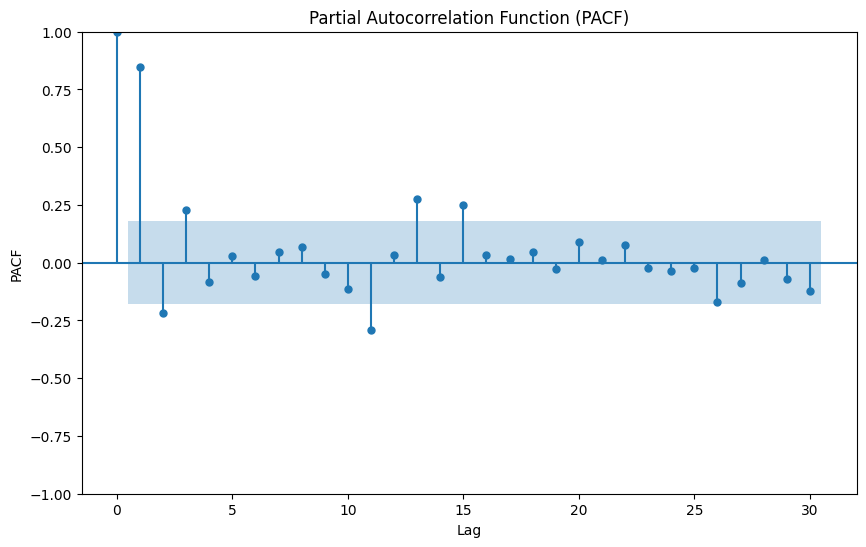

In [47]:
plt.figure(figsize=(10, 6))
plot_pacf(df['INFR'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()


In [51]:
result = adfuller(df['INFR'])



In [53]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.9776348492021176
p-value: 0.29646470451809726
Critical Values:
   1%: -3.492995948509562
   5%: -2.888954648057252
   10%: -2.58139291903223


In [ ]:
from worker.workflow import Workflow
from aimodels.base_model import BaseModel
from data_factory.data_factory import ModelDataFactory

In [ ]:
#TODO make lstm as custom instead of hardcoding the layers.
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size= 300, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(hidden_layer_size, 100)
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(100,output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out = self.dropout1(lstm_out)
        predictions = self.linear2(self.dropout2(self.linear1(lstm_out.view(len(input_seq), -1))))
        return predictions[-1]

class CustomLSTM(BaseModel):

    def __init__(self, config, datasourceId, datasource_name, workflow: Workflow):
        self.config = config
        self.train_data = None
        self.test_data =  None
        self.data_columns = []
        self.datasourceId =datasourceId
        self.datasource_name = datasource_name
        self.data_factory =  workflow.data_processor
        self.window_size = workflow.data_processor.window_size

        self.parse_config()
    
    def parse_config(self):
        self.epochs = self.config["epochs"]
        self.n_pred = self.config["days_ahead"]
        self.optimizer_name  = self.config["optimizer"]
        self.loss_function  = self.config["loss_function"]
        self.lr =  self.config["lr"]
        self.dropout  = self.config["dropout"]




    def get_loss(self):
        if self.loss_function == "MSE":
            return nn.MSELoss()
        else:
            raise Exception("Unable to find loss Function. Please specify correct loss function")
    
    def get_optimizer(self):
        if self.optimizer_name == "Adam":
            return torch.optim.Adam

    def build_model(self):
        model = LSTM()
        loss_function = self.get_loss()
        optimizer = self.get_optimizer()(model.parameters(), lr=self.lr)

        return model, loss_function, optimizer

    def train(self, train_data, test_data):
        self.train_data = train_data
        self.test_data  = test_data

        self.model, self.loss,self.optimizer = self.build_model()
        #training starts here

        self.model.train()
        for i in range(self.epochs):
            for seq, labels in self.train_data:
                self.optimizer.zero_grad()
                self.model.hidden_cell = (torch.zeros(1, 1, self.model.hidden_layer_size),
                                torch.zeros(1, 1, self.model.hidden_layer_size))

                y_pred = self.model(seq)

                single_loss = self.loss(y_pred, labels)
                single_loss.backward()
                self.optimizer.step()

            if i%25 == 1:
                print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

        last_training_point = np.array(self.train_data[-1][0].tolist() + self.train_data[-1][1].tolist()).reshape(-1)
        
        print(self.test_data)
        last_training_point = list(last_training_point)
        prediction_data = self.inference(self.model,last_training_point[1:], (self.test_data.index.max() - self.test_data.index.min()).days+4, start_date= self.test_data.index.min()-timedelta(days=1), end_date= self.test_data.index.max(), from_train=True)
        print(prediction_data)
        common_index = prediction_data.index.intersection(self.test_data.index)
        prediction_data = prediction_data.loc[common_index]

        print("Number of samples: ", len(prediction_data), len(self.test_data))
        error_metric = self.evaluate(self.test_data, prediction_data)

        self.save_plots(prediction_data, test_data)
        self.train_and_save_full_model()
        print(error_metric)
        return error_metric

    def train_and_save_full_model(self):
        #save model using mlflow 
        #create model here then pass it save model function.
        model, loss_function, optimizer = self.build_model()
        training_preds = []
        print(self.data_factory.full_data[0])
        for i in range(self.epochs):
            for seq, labels in self.data_factory.full_data:
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))

                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                single_loss.backward()
                optimizer.step()

                if (i+1 == self.epochs):
                    training_preds.append(float(y_pred.detach().numpy()))

            if i%25 == 1:
                print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
        self.save_model(model)

        training_preds = self.get_training_predictions(training_preds)
        self.save_data(training_preds)

    def evaluate(self,actual_data, prediction_data):
        """
        This funtion evaluates the performance of the model

        Args:
            prediction_data (_type_): last row in training data
            actual_data (_type_):  true data
        """
        # measured_data = actual_data[self.data_factory.output].to_numpy()
        mae_error = mean_absolute_error(prediction_data.squeeze(),actual_data)
        rmse_error = np.sqrt(mean_squared_error(prediction_data.squeeze(),actual_data))
        print("MAE: {}, RMSE: {}".format(mae_error,rmse_error))
        # print(self.config)
        return {"RMSE": rmse_error, "MAE": mae_error}
    
    def save_plots(self,prediction_data,test_data):
        print(test_data.head())
        plt.plot(test_data)
        plt.plot(test_data.index, prediction_data)
        print(self.datasource_name)
        plt.savefig(f"./save_plots/lstm/predicitions.png")
        # plt.show()
    
    def get_training_predictions(self,y_preds):
        
        print(self.data_factory.raw_data, len(y_preds))  
        preds_org = self.data_factory.raw_data.copy()[self.window_size:]
        y_preds = self.data_factory.scalar.inverse_transform(np.array(y_preds ).reshape(1, -1))[0]
        print(y_preds)
        preds_org[self.data_factory.output] = np.array(y_preds)
        preds_org = preds_org[[self.data_factory.output]]
        print(preds_org)  
        return preds_org
   
    
    def inference(self, model: LSTM, test_inputs: list, days_ahead = 50, start_date = datetime.now().date(), end_date = None, from_train = False):
        """
        This function do predictions for given number of days ahead

        Args:
            model (LSTM): lstm model
            test_inputs (list): this is the last training datapoint 
            days_ahed (int): Number of days forecasts needs to be done
        """
        # if start_date != None and end_date != None:
        #     days_ahead = end_date - start_date

        if start_date == None:
            start_date = datetime.now().date()
        if days_ahead == None:
            days_ahead = 50
        if end_date == None:
            end_date = start_date + timedelta(days_ahead)

        print(start_date)
        print(days_ahead)
        model.eval()

        for i in range(days_ahead):
            seq = torch.FloatTensor(test_inputs[-self.window_size:])
            with torch.no_grad():
                model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
                test_inputs.append(model(seq).item())

        actual_predictions = self.data_factory.scalar.inverse_transform(np.array(test_inputs[self.window_size:] ).reshape(1, -1))[0]

        days = pd.date_range(end_date - timedelta(days=days_ahead-1), end_date, freq='D')
        print(len(actual_predictions), days_ahead, len(days))

        preds = pd.DataFrame({'date': days, self.data_factory.output: actual_predictions})
        preds = preds.set_index('date')
        preds = preds[preds.index >= pd.to_datetime(start_date)] 
        print(preds.head())
        return preds
    

    def save_data(self, data, datasource_id= None):
        if datasource_id == None:
            datasource_id = self.datasourceId
        upload_data_to_db(data, "lstm", datasource_id)
        


if __name__=="__main__":
    obj = CustomLSTM()

In [ ]:
from datetime import datetime,timedelta
import pandas as pd
import logging
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from math import sqrt
import numpy as np
import warnings
from util.best_model import BestModel
from util.upload_data import upload_data_to_db
from mlflow.tracking import MlflowClient
from matplotlib import pyplot as plt
import mlflow
warnings.filterwarnings('ignore')

from worker.workflow import Workflow
from aimodels.base_model import BaseModel
from data_factory.data_factory import ModelDataFactory

# import prepare_data as pr

# import test_perform as tp
ws =['auto',False]

class AdvanceProphet(BaseModel):

    def __init__(self, config, station_id, station_name, workflow: Workflow):
        self.config = config
        self.train_data = None
        self.test_data =  None
        self.data_columns = []
        self.datasource_name = station_name
        self.data_factory =  workflow.data_processor

        self.parse_config()
    
    def parse_config(self):
        self.interval_width = self.config["interval_width"]
        self.n_pred = self.config["days_ahead"]
        self.sps  = self.config["sps"]
        self.cps  = self.config["cps"]
        self.sm =  self.config["sm"]
        self.ws  = self.config["ws"]
        self.plot_range = self.config["plot_range"]
        self.plot_pred_test = self.config["plot_pred_test"]

    def train(self, train_data, test_data):
        self.train_data = train_data
        self.test_data  = test_data

        try: 
            exp_id = mlflow.create_experiment(f"{self.datasource_name} - Forecast Models")
        except:
            exp_id = mlflow.get_experiment_by_name(f"{self.datasource_name} - Forecast Models").experiment_id

        print(exp_id)
        # print(exp_id.__dict__["_experiment_id"])
        # for station_id in range(1,20):
        #Num prediction
        # n_pred = 240
        
        # self.data_columns = test_data.columns
        # print(self.data_columns)
        #Changepoints feature and holiday features build
        changepoints, holidays = self.data_factory.holiday_changepoints_build()
    
        #Run model and produce results
        mlflow.start_run(experiment_id=exp_id, run_name=f"Prophet - {self.data_factory.output} - { datetime.now().replace(second=0, microsecond=0)}")

        error_metric = self.perform_prophet(self.station_id,train_data = train_data,
                        test_data= test_data,
                        n_pred= self.n_pred,
                        changepoints= changepoints,
                        holidays= holidays,
                        ws= self.ws,
                        station_no= self.station_id,
                        save_fig= True,
                        plot_pred_test=self.plot_pred_test, 
                        plot_range= self.plot_range)

        full_data = pd.concat([self.train_data, self.test_data], axis=0)
        self.train_and_save_full_model(full_data, changepoints= changepoints,
                        holidays= holidays,
                        sps=10.0,
                        cps=0.05,
                        ws = 'auto',
                        sm='additive',
                        add_national_holiday=False)
        mlflow.end_run()

        return error_metric

    def run_prophet(self,station_id,train_data, n_pred,
                        changepoints=None,
                        holidays=None,
                        sps=10.0,
                        cps=0.05,
                        ws = 'auto',
                        sm='additive',
                        add_national_holiday=False):
        
        mlflow.set_tag("With Changepoints","True")
        mlflow.set_tag("With Holidays","False")
       
        mlflow.log_param("seasonality_prior_scale",str(sps))
        mlflow.log_param("changepoint_prior_scale",str(cps))
        mlflow.log_param("interval_width", "0.95")
        mlflow.log_param("weekly_seasonality", ws)
        mlflow.log_param("seasonality_mode", sm)

        model = Prophet(interval_width=self.interval_width,
                        changepoints=changepoints,
                        holidays=holidays,
                        seasonality_prior_scale=sps,
                        changepoint_prior_scale=cps,
                        weekly_seasonality= ws,
                        seasonality_mode=sm)

        if add_national_holiday == True:
            model.add_country_holidays('IN')
        
        model.fit(train_data)
        # mlflow.prophet.log_model(model, artifact_path="model", registered_model_name=f"{self.datasource_name}_{self.data_factory.output}_prophet")
        print(self.test_data)
        print("number of pred days",(self.test_data['ds'].max() - self.test_data['ds'].min()).days)
        future_dates = model.make_future_dataframe(periods=(self.test_data['ds'].max() - self.test_data['ds'].min()).days, include_history=False)
        prediction = model.predict(future_dates)
        fitting_graph = plot_plotly(model, prediction)
        
        model.plot_components(prediction).savefig('./save_plots/Components_of_model.png')
        mlflow.log_artifact("./save_plots/prophet_models/Components_of_model.png",artifact_path="plots")

        model.plot(prediction).savefig("./save_plots/predictions_of_model.png")
        mlflow.log_artifact("./save_plots/prophet_models/predictions_of_model.png",artifact_path="plots")

        return prediction, fitting_graph
    

    def perform_prophet(self,station_id,train_data, test_data,
                    n_pred,
                    changepoints=None,
                    holidays=None,
                    sps=10.0,
                    cps=0.25,
                    sm='additive',
                    ws ='auto',
                    plot_range=False,
                    plot_pred_test = False,
                    set_yrange=False,
                    station_no=None,
                    save_fig=False):
        # try:

            # Model with lockdown as changepoints.
            prediction_with_lockdown, fit_holiday = self.run_prophet(station_id,train_data, n_pred=n_pred, changepoints=changepoints,
                                                                ws=ws)
            
            pred = prediction_with_lockdown.tail(self.n_pred)
            pred_org = pred[['ds', 'yhat']].set_index('ds')
            # print("jhgvtf ",pred_org)
            print(test_data[["y"]])
            upload_data = pred_org.copy()
            upload_data = upload_data.rename(columns={'yhat': 'PM10'})
            # upload_data_to_db(upload_data, "prophet",station_id)

            
            mod_pred = pred_org.copy()
            dummy_test = test_data.copy()
            dummy_test = dummy_test.set_index('ds')
            # print(mod_pred, dummy_test)
            mod_pred['y'] = dummy_test[["y"]]
            # print("after adding y",mod_pred)
            mod_pred = mod_pred.dropna()
            
            # print(len(mod_pred))
            
            error_rmse = sqrt(mean_squared_error(mod_pred.yhat, mod_pred.y))
            error_mae = mean_absolute_error(mod_pred.yhat, mod_pred.y)
            
            mlflow.log_metric("RMSE Score", error_rmse)
            mlflow.log_metric("MAE Score",error_mae)
            print(f'Model with lockdown as change points --->  RMSE: {error_rmse:.2f}, MAE: {error_mae:.2f}')
            print(plot_pred_test, plot_range)

            plt.plot(mod_pred.drop(['y'], axis=1), color='#ebd500', label='Predicted (lockdown as changepoints)')
            plt.savefig("./save_plots/prophet_models/predicitions.png")
            mlflow.log_artifact("./save_plots/prophet_models/predicitions.png",artifact_path="plots")
            if plot_pred_test == True and plot_range == False:
                plt.plot(mod_pred.drop(['y'], axis=1), color='#ebd500', label='Predicted (lockdown as changepoints)')
                plt.savefig("./save_plots/prophet_models/predicitions.png")
                mlflow.log_artifact("./save_plots/prophet_models/predicitions.png",artifact_path="plots")
            elif plot_pred_test == False and plot_range == True:
                pred = prediction_with_lockdown.tail(n_pred).set_index('ds')
                plt.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], edgecolor='#ebd500',
                                facecolor='#ebd500', alpha=0.3, label='Predicted (lockdown as changepoints)')
            elif plot_pred_test == True and plot_range == True:
                print(f'Wrong choice of plot settings!!')
            else:
                plt.plot(pred_org, color='#ebd500', label='Predicted (lockdown as changepoints)')
            
            return {"RMSE" :error_rmse ,"MAE": error_mae}
        # except:
        #     print('Error occured while building model!!!')
    
    def train_and_save_full_model(self,full_data, 
                        changepoints=None,
                        holidays=None,
                        sps=10.0,
                        cps=0.05,
                        ws = 'auto',
                        sm='additive',
                        add_national_holiday=False):
        
        print("fullll datattattatt",full_data)
        model = Prophet(interval_width=self.interval_width,
                        changepoints=changepoints,
                        holidays=holidays,
                        seasonality_prior_scale=sps,
                        changepoint_prior_scale=cps,
                        weekly_seasonality= ws,
                        seasonality_mode=sm)

        if add_national_holiday == True:
            model.add_country_holidays('IN')

        model.fit(full_data)

        training_preds = self.get_training_predictions(model)
        self.save_data(training_preds)
        model_info = mlflow.prophet.log_model(model, artifact_path="model", registered_model_name=f"{self.datasource_name}_{self.data_factory.output}_prophet")
        print(model_info)

    def get_training_predictions(self, model: Prophet):
        
        future_dates = model.make_future_dataframe(periods=0, include_history=True)
        print(future_dates)
        predictions = model.predict(future_dates)

        pred_org = predictions[['ds', 'yhat']].set_index('ds')
        pred_org = pred_org.rename(columns={'yhat': self.data_factory.output}) 
       
        print(pred_org)
        return pred_org
    

    def inference(self, model: Prophet, test_inputs: list = None, days_ahead = None, start_date = None ,  end_date = None, from_train = False):
        
        if start_date == None:
            start_date = datetime.now().date()
            print("Start date is not provided taking default value")
        
        if end_date == None:
            end_date = start_date + timedelta(days_ahead)

        print("days_ahead",days_ahead)
        future_dates = model.make_future_dataframe(periods=days_ahead, include_history=False)
        print(future_dates)
        predictions = model.predict(future_dates)

        pred_org = predictions[['ds', 'yhat']].set_index('ds')
        pred_org = pred_org.rename(columns={'yhat': self.data_factory.output})  

        print(pred_org, len(pred_org))
        pred_org = pred_org[pred_org.index >= pd.to_datetime(start_date)]      
       
        # print(pred_org.head)
        return pred_org
    
    def save_data(self, data, datasource_id= None):
        if datasource_id == None:
            datasource_id = self.station_id
        upload_data_to_db(data, "prophet", datasource_id)


if __name__=="__main__":
    obj = AdvanceProphet()
    obj.run_model()

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

train, test = train_test_split(df, test_size=0.15, shuffle=False)  # Splitting chronologically

# 4. Model Training
X_train = train[['Time']]  # Features
y_train = train['INFR']   # Target variable

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Model Evaluation
X_test = test[['Time']]
y_test = test['INFR']

y_pred = rf.predict(X_train)

mae = mean_squared_error(y_train, y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.04870182572450963


In [68]:
y_pred

array([7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386,
       7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386, 7.2386,
       7.2386, 7.2386])

In [146]:
df


,Time,INFR
0,2014-04-01,8.483
1,2014-05-01,8.326
2,2014-06-01,6.770
3,2014-07-01,7.387
4,2014-08-01,7.028
...,...,...
115,2023-11-01,5.550
116,2023-12-01,5.690
117,2024-01-01,5.100
118,2024-02-01,5.090


In [150]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Assuming df is your dataframe with 'time' and 'value' columns

# Prepare data
# df = df.set_index('Time')
# df.index = pd.to_datetime(df.index)

# Fit ARIMA model
model = ARIMA(df, order=(0, 1, 2))  # You may need to adjust the order based on your data characteristics
arima_result = model.fit()

# Forecasting
forecast_steps = 3  # Forecasting 10 steps ahead
forecast = arima_result.forecast(steps=forecast_steps)

# Print MAE (if you have a testing set)
# For illustration purposes, let's split the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA model on training data
model_train = ARIMA(train, order=(0, 1, 2))
arima_result_train = model_train.fit()

# mae = mean_absolute_error(train, arima_result_train)
# print("Mean Absolute Error:", mae)

# Print Forecasted values

/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

In [159]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Assuming df is your dataframe with 'Time' and 'INFR' columns

# Splitting data
train, test = train_test_split(df, test_size=0.15, shuffle=False)

# Training data
train_data = train['INFR']
test_data = test['INFR']

# Fit ARIMA model
order = (0, 1, 2) # Example order
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Forecasting
y_test_pred = model_fit.forecast(steps=len(test))

# Calculate MAE
test_mae = mean_absolute_error(test_data, y_test_pred)
print("Test MAE:", test_mae)


Test MAE: 1.7129398768572814


/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/vikas/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [84]:
from pmdarima import auto_arima

# Assuming df is your dataframe with 'time' and 'value' columns

# Prepare data
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)

# Find optimal parameters
model = auto_arima(df, seasonal=False, trace=True, suppress_warnings=True)

print("Optimal p,d,q parameters:", model.order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=270.440, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.670, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=275.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=272.961, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=274.861, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=268.442, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=267.532, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=268.515, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=271.222, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=270.442, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=265.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=271.080, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=266.656, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=266.729, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=269.3

In [79]:
df

,INFR
Time,
2014-04-01,8.483
2014-05-01,8.326
2014-06-01,6.770
2014-07-01,7.387
2014-08-01,7.028
...,...
2023-11-01,5.550
2023-12-01,5.690
2024-01-01,5.100


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-04-01 to 2024-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INFR    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [134]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Assuming df is your dataframe with 'time' and 'value' columns

# Prepare data
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA model on training data
history = [x for x in train['INFR']]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))  # Adjust order as needed
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)

# Calculate MAE for each step
mae = [mean_absolute_error(test[:i+1], predictions[:i+1]) for i in range(len(test))]

# Plot learning curve
plt.plot(range(1, len(test) + 1), mae, marker='o')
plt.xlabel('Number of Observations')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve')
plt.show()


/home/vikas/.local/lib/python3.10/site-packages/statsmodels/base/data.py:670: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

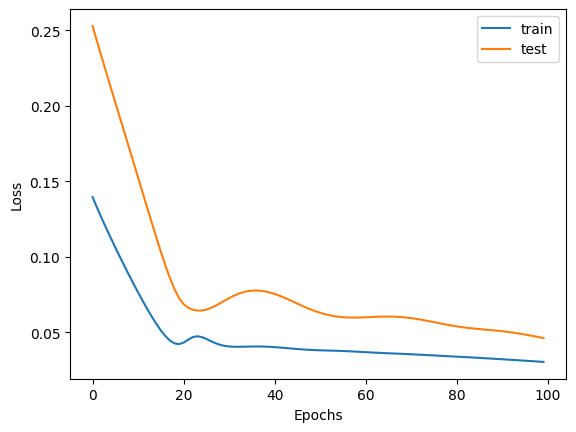

Mean Absolute Error: 1.2052086019437918


In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming df is your dataframe with 'time' and 'value' columns

# Normalize the data
scaler = MinMaxScaler()
df['value_normalized'] = scaler.fit_transform(df[['INFR']])

# Convert time series data to supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_supervised = data.copy()
    cols = []
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_supervised.shift(i))
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_supervised.shift(-i))
    df_supervised = pd.concat(cols, axis=1)
    if dropnan:
        df_supervised.dropna(inplace=True)
    return df_supervised.values

# Hyperparameters
n_steps_in = 3  # Number of input timesteps
n_steps_out = 1  # Number of output timesteps
n_features = 1  # Number of features

# Convert time series to supervised learning
data = series_to_supervised(df[['value_normalized']], n_in=n_steps_in, n_out=n_steps_out)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Split data into input X and output y
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Initialize model, loss function, and optimizer
model = LSTMModel(n_features, 50, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train LSTM model
train_losses = []
test_losses = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(torch.Tensor(X_train))
    loss = criterion(output.squeeze(), torch.Tensor(y_train))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    with torch.no_grad():
        model.eval()
        test_output = model(torch.Tensor(X_test))
        test_loss = criterion(test_output.squeeze(), torch.Tensor(y_test))
        test_losses.append(test_loss.item())

# Plot learning curves
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Forecasting
with torch.no_grad():
    model.eval()
    y_pred = model(torch.Tensor(X_train))

# Denormalize the predictions
y_pred_denormalized = scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1))
y_test_denormalized = scaler.inverse_transform(y_train.reshape(-1, 1))
# Print Mean Absolute Error
mae = np.sqrt(np.mean((y_test_denormalized - y_pred_denormalized)**2))
print("Mean Absolute Error:", mae)


In [121]:
y_pred_denormalized

array([[3.2818487],
       [4.219711 ],
       [4.819497 ],
       [5.209809 ],
       [5.4164705],
       [5.566158 ],
       [5.704181 ],
       [5.716559 ],
       [5.601448 ],
       [5.4814153],
       [5.4841604],
       [5.483632 ],
       [5.391927 ],
       [5.2040634],
       [5.013554 ],
       [4.9406986],
       [5.200836 ],
       [5.3470154],
       [5.2384243],
       [5.1225843],
       [5.111563 ],
       [5.1253023],
       [5.069396 ],
       [5.0246687]], dtype=float32)

In [122]:
y_test_denormalized

array([[7.79],
       [7.04],
       [7.01],
       [6.71],
       [7.  ],
       [7.41],
       [6.77],
       [5.88],
       [5.72],
       [6.52],
       [6.44],
       [5.66],
       [4.7 ],
       [4.31],
       [4.87],
       [7.44],
       [6.83],
       [5.02],
       [4.87],
       [5.55],
       [5.69],
       [5.1 ],
       [5.09],
       [4.85]])

In [129]:
df

,Time,INFR
0,2014-04-01,8.483
1,2014-05-01,8.326
2,2014-06-01,6.770
3,2014-07-01,7.387
4,2014-08-01,7.028
...,...,...
115,2023-11-01,5.550
116,2023-12-01,5.690
117,2024-01-01,5.100
118,2024-02-01,5.090


In [115]:
y_pred - y_test


tensor([[-0.6710, -0.5630, -0.5587, -0.5155, -0.5572, -0.6163, -0.5241, -0.3959,
         -0.3729, -0.4881, -0.4766, -0.3642, -0.2260, -0.1698, -0.2505, -0.6206,
         -0.5328, -0.2721, -0.2505, -0.3484, -0.3686, -0.2836, -0.2821, -0.2476],
        [-0.5399, -0.4318, -0.4275, -0.3843, -0.4261, -0.4851, -0.3930, -0.2648,
         -0.2417, -0.3569, -0.3454, -0.2331, -0.0948, -0.0386, -0.1193, -0.4895,
         -0.4016, -0.1409, -0.1193, -0.2172, -0.2374, -0.1524, -0.1510, -0.1164],
        [-0.4549, -0.3469, -0.3426, -0.2993, -0.3411, -0.4002, -0.3080, -0.1798,
         -0.1568, -0.2720, -0.2605, -0.1481, -0.0098,  0.0463, -0.0343, -0.4045,
         -0.3166, -0.0559, -0.0343, -0.1323, -0.1524, -0.0675, -0.0660, -0.0315],
        [-0.3974, -0.2894, -0.2851, -0.2419, -0.2836, -0.3427, -0.2505, -0.1223,
         -0.0993, -0.2145, -0.2030, -0.0906,  0.0476,  0.1038,  0.0232, -0.3470,
         -0.2591,  0.0016,  0.0232, -0.0748, -0.0949, -0.0100, -0.0085,  0.0260],
        [-0.3650, -0.257

In [111]:
rmse = np.sqrt(np.mean((y_test - y_pred_denormalized)**2))
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 4.51807049078349


In [110]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

# Assuming df is your dataframe with 'time' and 'value' columns

# Prepare data
df = df.rename(columns={'time': 'ds', 'value': 'y'})

# Initialize and fit Prophet model
model = Prophet()
model.fit(df)

# Make future dataframe
future = model.make_future_dataframe(periods=10, freq='D')  # Forecasting 10 days into the future

# Forecast
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecast using Prophet')
plt.show()

# Print Mean Absolute Error
# Assuming you have a test set for comparison
test = df.iloc[-10:]
mae = np.mean(np.abs(test['y'] - forecast.iloc[-10:]['yhat']))
print("Mean Absolute Error:", mae)


ModuleNotFoundError: No module named 'fbprophet'

NameError: name 'auto_arima' is not defined